# Analysis with Spark on News Data

 ####                                                                                                                                            CS 779 Final DEMO by Oindrilla Chatterjee 12/09/2018

## Import the neccesary libraries

In [1]:
from __future__ import print_function
from datetime import datetime
import sys
import csv
import glob
import re
import string
import time
import pandas as pd
from plotly.offline import plot,iplot
import Load_MasterDictionary as LM
import plotly.graph_objs as go
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import lit, to_date, sum
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

## Read in the json file with all scraped data

## Components of Spark
### The following illustration depicts the different components of Spark

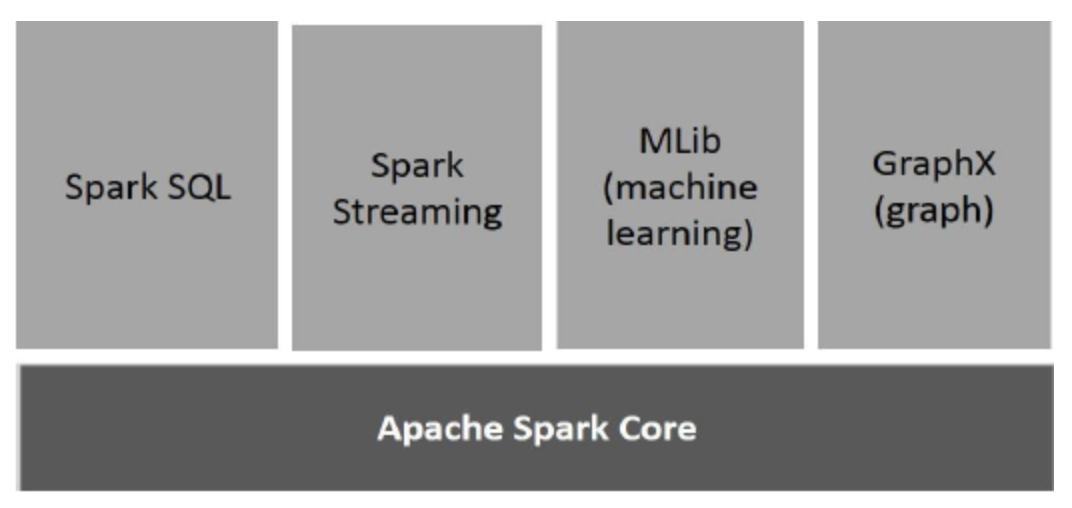

### Apache Spark Core
Spark Core is the underlying general execution engine for spark platform that all other functionality is built upon. It provides In-Memory computing and referencing datasets in external storage systems.

#### Spark SQL
Spark SQL is a component on top of Spark Core that introduces a new data abstraction called SchemaRDD, which provides support for structured and semi-structured data.

#### Spark Streaming
Spark Streaming leverages Spark Core's fast scheduling capability to perform streaming analytics. It ingests data in mini-batches and performs RDD (Resilient Distributed Datasets) transformations on those mini-batches of data.

#### MLlib (Machine Learning Library)
MLlib is a distributed machine learning framework above Spark because of the distributed memory-based Spark architecture. It is, according to benchmarks, done by the MLlib developers against the Alternating Least Squares (ALS) implementations. Spark MLlib is nine times as fast as the Hadoop disk-based version of Apache Mahout (before Mahout gained a Spark interface).

#### GraphX
GraphX is a distributed graph-processing framework on top of Spark. It provides an API for expressing graph computation that can model the user-defined graphs by using Pregel abstraction API. It also provides an optimized runtime for this abstraction.

### Build a Spark session and create a Spark Context

In [2]:

#Creating the spark session
spark = SparkSession \
.builder \
.appName("Counting_Articles") \
.getOrCreate()

#Creating the spark context
sc = spark.sparkContext

### Read in the data in form of a Spark RDD using the SparkContext we just created

In [3]:
total_news_2014 = sc.textFile("2014facebook.json")

Let us see how the input looks like

In [4]:
total_news_2014.take(2)

['{ "url": "http://www.reuters.com/article/2014/01/02/snapchat-hacking-idUSL3N0KC0AH20140102", "title": "Hackers post account info of 4.6 mln Snapchat users - report", "dop": "20140101 10:42 AM", "text": "Jan 1 (Reuters) - Computer hackers posted online usernames and partial phone numbers of 4.6 million users of mobile photo-sharing service Snapchat, media reports said on Wednesday.  A website called SnapchatDB.info made the information available for download, according to tech news site TechCrunch. (link.reuters.com/wyg75v)  As on Wednesday night, the site SnapchatDB.info has been suspended.  In a statement to TecCrunch, SnapchatDB said that it got the information through a recently identified and patched Snapchat exploit and that it was making the data available in an effort to convince the messaging app to beef up its security.  With Snapchat, users can send photos and videos that disappear shortly after they are viewed and have been lately gaining popularity especially among young 

### Now I need, for my analysis, from the above json, URL, Title, DOP, Text for each artile

#### Thus, I will create a function to index from the above json and read in the fields into a Spark Dataframe

Spark SQL can automatically capture the schema of a JSON dataset and load it as a DataFrame. This conversion can be done using SQLContext.read.json() on either an RDD of String or a JSON file. But I am not using that functionality here since my data source was initialy in .txt form and this code is compatible with both

In [5]:
def IndexFields(x):
    url_index = x.index('"url":')
    title_index = x.index('"title":')
    dop_index = x.index('"dop":')
    text_index = x.index('"text":')
    
    url_from = url_index+7
    url_to = title_index-2
    title_from = title_index+9
    title_to = dop_index-2
    dop_from = dop_index+7
    dop_to = text_index-2
    text_from = text_index+8

    url = x[url_from:url_to]
    title = x[title_from:title_to]
    dop = x[dop_from:dop_to]
    text = x[text_from:-2]
    
    return (url,title,dop[1:5]+'-'+dop[5:7]+'-'+dop[7:9],text)

### Run it on the RDD to see the resultant RDD

In [6]:
news_2014_url_title = total_news_2014.map(lambda x:IndexFields(x))

### Thus, we converted the string formatted article to dictionary and this is how it looks like

In [7]:
news_2014_url_title.take(2)

[('"http://www.reuters.com/article/2014/01/02/snapchat-hacking-idUSL3N0KC0AH20140102"',
  '"Hackers post account info of 4.6 mln Snapchat users - report"',
  '2014-01-01',
  '"Jan 1 (Reuters) - Computer hackers posted online usernames and partial phone numbers of 4.6 million users of mobile photo-sharing service Snapchat, media reports said on Wednesday.  A website called SnapchatDB.info made the information available for download, according to tech news site TechCrunch. (link.reuters.com/wyg75v)  As on Wednesday night, the site SnapchatDB.info has been suspended.  In a statement to TecCrunch, SnapchatDB said that it got the information through a recently identified and patched Snapchat exploit and that it was making the data available in an effort to convince the messaging app to beef up its security.  With Snapchat, users can send photos and videos that disappear shortly after they are viewed and have been lately gaining popularity especially among young users.  Snapchat drew attenti

### Create a structure schema to store the above to a Dataframe

In [9]:
#Creating the schema
schema = StructType([
    StructField('Url',StringType(),True),
    StructField('Title',StringType(),True),
    StructField('Dop',StringType(),True),
    StructField('Text',StringType(),True),
])

### Spark Dataframe

Here is a set of few characteristic features of DataFrame −

* Ability to process the data in the size of Kilobytes to Petabytes on a single node cluster to large cluster.

* Supports different data formats (Avro, csv, elastic search, and Cassandra) and storage systems (HDFS, HIVE tables, mysql, etc).

* State of art optimization and code generation through the Spark SQL Catalyst optimizer (tree transformation framework).

* Can be easily integrated with all Big Data tools and frameworks via Spark-Core.

* Provides API for Python, Java, Scala, and R Programming.

### Use the defined Schema and RDD to convert to a Dataframe

In [10]:
news_url_title_df = spark.createDataFrame(news_2014_url_title,schema)

### Display the Dataframe

In [11]:
news_url_title_df.show(4)

+--------------------+--------------------+----------+--------------------+
|                 Url|               Title|       Dop|                Text|
+--------------------+--------------------+----------+--------------------+
|"http://www.reute...|"Hackers post acc...|2014-01-01|"Jan 1 (Reuters) ...|
|"http://www.reute...|"Syrian Electroni...|2014-01-01|"LOS ANGELES, Jan...|
|"http://www.reute...|"Two killed in cl...|2014-01-01|"CAIRO (Reuters) ...|
|"http://www.reute...|"Snapchat says mi...|2014-01-02|"SAN FRANCISCO (R...|
+--------------------+--------------------+----------+--------------------+
only showing top 4 rows



## Sentiment Analysis on the above text from Dataframe

### Perform Tokenization on the text for further processing

In [12]:
from pyspark.ml.feature import Tokenizer


tokenizer = Tokenizer(inputCol="Text", outputCol="Text_Vector")
news_url_title_df_tokenized = tokenizer.transform(news_url_title_df).select('Url','Title','Dop','Text_Vector')



#### Tokenized text looks as follows




In [15]:
news_url_title_df_tokenized.show(2, False)

+----------------------------------------------------------------------------------+-----------------------------------------------------------------------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Remove Stopwords from text

Stopwords are commonly occuring, often known as "grammar words", which do not hold a lot of significance in order to chnage the meaning of the text. It is processed and removed out in Natural Language Processing

In [16]:

from pyspark.ml.feature import StopWordsRemover

# Define a list of stop words or use default list
remover = StopWordsRemover()
stopwords = remover.getStopWords() 

#### List of Stopwords used here

In [17]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

#### Removing stopwords

In [18]:
# Specify input/output columns
remover.setInputCol("Text_Vector")
remover.setOutputCol("vector_no_stopw")

# Transform existing dataframe with the StopWordsRemover
news_url_title_df_stops_removed = remover.transform(news_url_title_df_tokenized).select('Url','Title','Dop','vector_no_stopw')



#### Text after removing stopwords

In [22]:
#news_url_title_df_stops_removed.show(2)
news_url_title_df_stops_removed.show(2)

+--------------------+--------------------+----------+--------------------+
|                 Url|               Title|       Dop|     vector_no_stopw|
+--------------------+--------------------+----------+--------------------+
|"http://www.reute...|"Hackers post acc...|2014-01-01|["jan, 1, (reuter...|
|"http://www.reute...|"Syrian Electroni...|2014-01-01|["los, angeles,, ...|
+--------------------+--------------------+----------+--------------------+
only showing top 2 rows



### Describe the function for Sentiment Analysis

In [21]:
MASTER_DICTIONARY_FILE = r'LoughranMcDonald_MasterDictionary_2014.csv'
lm_dictionary = LM.load_masterdictionary(MASTER_DICTIONARY_FILE, True)

 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  LoughranMcDonald_MasterDictionary_2014.csv
  85,131 words loaded in master_dictionary.



In [24]:

def get_data(ip):
    
    doc =  ' '.join(ip)
    doc = doc.upper()
    vdictionary = {}
    _odata = [0] * 3
    total_syllables = 0
    word_length = 0
    
    tokens = re.findall('\w+', doc)  # Note that \w+ splits hyphenated words
    for token in tokens:
        if not token.isdigit() and len(token) > 1 and token in lm_dictionary:
            _odata[0] += 1  # word count
            word_length += len(token)
            if token not in vdictionary:
                vdictionary[token] = 1
            if lm_dictionary[token].positive: _odata[1] += 1
            if lm_dictionary[token].negative: _odata[2] += 1
    
        
    return _odata

## Need to apply this on every row of the Text in Dataframe to calculate sentiment score

### Create a User Defined Function UDF to apply this function to each row of the text column in Spark Dataframe

User-defined functions (UDFs) are a key feature of most SQL environments to extend the system’s built-in functionality. UDFs allow developers to enable new functions in higher level languages such as SQL by abstracting their lower level language implementations. Apache Spark is no exception, and offers a wide range of options for integrating UDFs with Spark SQL workflows.

Spark SQL supports integration of existing Hive (Java or Scala) implementations of UDFs

In [25]:
# Apply sentiment analysis on stopwords removed text and add column odata

from pyspark.sql.types import *
from pyspark.sql.functions import udf

# User defined function for applying sentiment analysis
udf_object = udf(get_data, ArrayType(StringType()))
new_df = news_url_title_df_stops_removed.withColumn("Sentiment_Vector", udf_object("vector_no_stopw"))

### Output Dataframe with Sentiment Vector : [No. of words, Postive Words, Negative Words]

In [26]:
new_df.show()

+--------------------+--------------------+----------+--------------------+----------------+
|                 Url|               Title|       Dop|     vector_no_stopw|Sentiment_Vector|
+--------------------+--------------------+----------+--------------------+----------------+
|"http://www.reute...|"Hackers post acc...|2014-01-01|["jan, 1, (reuter...|      [88, 2, 3]|
|"http://www.reute...|"Syrian Electroni...|2014-01-01|["los, angeles,, ...|     [208, 0, 8]|
|"http://www.reute...|"Two killed in cl...|2014-01-01|["cairo, (reuters...|    [288, 1, 34]|
|"http://www.reute...|"Snapchat says mi...|2014-01-02|["san, francisco,...|    [271, 3, 15]|
|"http://www.reute...|"Snapchat says mi...|2014-01-02|["san, francisco,...|    [271, 3, 15]|
|"http://www.reute...|"Ride service Ube...|2014-01-02|["san, francisco,...|    [723, 8, 26]|
|"http://www.reute...|"UPDATE 1-Ride se...|2014-01-02|["by, sarah, mcbr...|    [718, 8, 26]|
|"http://www.reute...|"Skype says user ...|2014-01-02|["los, angeles, 

### Calculate the Sentiment Score associated with each text, (Positive score - Ndegative Score)

In [27]:
def sentiment_score(sent_list):
    
    sent_score = float(sent_list[1]) - float(sent_list[2])
    return sent_score

In [28]:
def positive_score(sent_list):
    
    return sent_list[1]

In [29]:
def negative_score(sent_list):
    
    return sent_list[2]

### Also here, create a User Defined Function UDF to apply this function to each row of the text column

In [30]:
# Adding TotalScoreSum Column

udf_object1 = udf(sentiment_score, DoubleType())
new_df1 = new_df.withColumn("TotalScoreSum", udf_object1("Sentiment_Vector"))

In [31]:
# Adding PositiveScoreSum Column

udf_object2 = udf(positive_score,IntegerType())
new_df2 = new_df1.withColumn("PositiveScoreSum", udf_object2("Sentiment_Vector"))

In [32]:
# Adding NegativeScoreSum Column

udf_object3 = udf(negative_score, IntegerType())
new_df3 = new_df2.withColumn("NegativeScoreSum", udf_object3("Sentiment_Vector"))

In [33]:
new_df3.show(2)

+--------------------+--------------------+----------+--------------------+----------------+-------------+----------------+----------------+
|                 Url|               Title|       Dop|     vector_no_stopw|Sentiment_Vector|TotalScoreSum|PositiveScoreSum|NegativeScoreSum|
+--------------------+--------------------+----------+--------------------+----------------+-------------+----------------+----------------+
|"http://www.reute...|"Hackers post acc...|2014-01-01|["jan, 1, (reuter...|      [88, 2, 3]|         -1.0|               2|               3|
|"http://www.reute...|"Syrian Electroni...|2014-01-01|["los, angeles,, ...|     [208, 0, 8]|         -8.0|               0|               8|
+--------------------+--------------------+----------+--------------------+----------------+-------------+----------------+----------------+
only showing top 2 rows



## Group the Dataframe by Date and sum on the Sentiment scores for a day

In [35]:
# Group by date and sum on sentiment score
from pyspark.sql import functions as F

dateAndScore = new_df3.groupBy("Dop").agg(F.count("TotalScoreSum"),sum("TotalScoreSum"),sum("PositiveScoreSum"),sum("NegativeScoreSum")).orderBy('Dop', ascending=True)
dateAndScore.show(10)

+----------+--------------------+------------------+---------------------+---------------------+
|       Dop|count(TotalScoreSum)|sum(TotalScoreSum)|sum(PositiveScoreSum)|sum(NegativeScoreSum)|
+----------+--------------------+------------------+---------------------+---------------------+
|2014-01-01|                   3|             -42.0|                    3|                   45|
|2014-01-02|                  14|            -128.0|                   63|                  191|
|2014-01-03|                   2|              -5.0|                   17|                   22|
|2014-01-05|                   2|             -69.0|                   19|                   88|
|2014-01-06|                  11|             -61.0|                   40|                  101|
|2014-01-07|                  10|             -58.0|                   48|                  106|
|2014-01-08|                  11|             -33.0|                   51|                   84|
|2014-01-09|                  

In [36]:
dateAndScoreValue = dateAndScore.withColumn("TotalNormalizedScore", dateAndScore['sum(TotalScoreSum)']/dateAndScore['count(TotalScoreSum)'])\
        .withColumn("PositiveNormalizedScore", dateAndScore['sum(PositiveScoreSum)']/dateAndScore['count(TotalScoreSum)'])\
        .withColumn("NegativeNormalizedScore", dateAndScore['sum(NegativeScoreSum)']/dateAndScore['count(TotalScoreSum)'])

In [37]:
dateAndScoreValue.show(2)

+----------+--------------------+------------------+---------------------+---------------------+--------------------+-----------------------+-----------------------+
|       Dop|count(TotalScoreSum)|sum(TotalScoreSum)|sum(PositiveScoreSum)|sum(NegativeScoreSum)|TotalNormalizedScore|PositiveNormalizedScore|NegativeNormalizedScore|
+----------+--------------------+------------------+---------------------+---------------------+--------------------+-----------------------+-----------------------+
|2014-01-01|                   3|             -42.0|                    3|                   45|               -14.0|                    1.0|                   15.0|
|2014-01-02|                  14|            -128.0|                   63|                  191|  -9.142857142857142|                    4.5|     13.642857142857142|
+----------+--------------------+------------------+---------------------+---------------------+--------------------+-----------------------+-----------------------+
only

### Drop all the unnecessary columns

In [38]:
drop_list = ['count(TotalScoreSum)', 'sum(TotalScoreSum)', 'sum(PositiveScoreSum)','sum(NegativeScoreSum)']

dateAndScore = dateAndScoreValue.select([column for column in dateAndScoreValue.columns if column not in drop_list])

In [39]:
dateAndScore.show(10)

+----------+--------------------+-----------------------+-----------------------+
|       Dop|TotalNormalizedScore|PositiveNormalizedScore|NegativeNormalizedScore|
+----------+--------------------+-----------------------+-----------------------+
|2014-01-01|               -14.0|                    1.0|                   15.0|
|2014-01-02|  -9.142857142857142|                    4.5|     13.642857142857142|
|2014-01-03|                -2.5|                    8.5|                   11.0|
|2014-01-05|               -34.5|                    9.5|                   44.0|
|2014-01-06|  -5.545454545454546|     3.6363636363636362|      9.181818181818182|
|2014-01-07|                -5.8|                    4.8|                   10.6|
|2014-01-08|                -3.0|      4.636363636363637|      7.636363636363637|
|2014-01-09|  -8.777777777777779|     2.7777777777777777|     11.555555555555555|
|2014-01-10|               -10.0|                   3.75|                  13.75|
|2014-01-11|    

## Export this Dataframe to a Plot using Plotly

In [40]:
def image_to_html(division_data):
    return """
    <!DOCTYPE html>
    <html>
      <head>
        <title>News Article Count</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
      </head>
      <body>
        <div>
          {}
        </div>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
      </body>
    </html>
    """.format(division_data)



In [41]:
def plot_graph(articles_count_pandas, col, range_set, ip_color, par):
    
    #Creating the graph with the range slider
    # first providing the data for the line
    trace0 = go.Scatter(
        x = articles_count_pandas["Dop"],
        y = articles_count_pandas[col],
        name = "Datewise sentiment score",
        line = dict(color = ip_color),
        opacity=0.8)

    data = [trace0]

    #Providing the layout info
    layout = dict(
        title= 'A plot of '+ par + ' of news articles count from {} to {}'.format(staringdate_new,endingdate_new),
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label='1m',
                        step='month',
                        stepmode='backward'),
                    dict(count=6,
                        label='6m',
                        step='month',
                        stepmode='backward'),
                    dict(count=7,
                        label='7d',
                        step='day',
                        stepmode='backward'),
                    dict(count=15,
                        label='15d',
                        step='day',
                        stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider = dict(
                visible=True
            ),
            type='date'

        ),
        yaxis=dict(
            title='Sentiment of articles',
            range=range_set
        )

    )

    #data and layout for the figure
    fig = dict(data=data,layout=layout)

    #html division tag is the output
    html_division = plot(fig,output_type='div')

    # Inserting the chart into a division
    html_script = image_to_html(html_division)


    with open(col + 'sentimentplot.html','w') as imgToHtml:
        imgToHtml.write(html_script)

In [42]:
col1 = 'TotalNormalizedScore'
col2 = 'PositiveNormalizedScore'
col3 = 'NegativeNormalizedScore'
color1 = '#9932CC'
color2 = '#17BECF'
color3 = '#ff0000'
par1 = 'Total Sentiment Scores'
par2 = 'Positive Sentiment Scores'
par3 = 'Negative Sentiment Scores'

In [43]:
# temporary assignment
# providing start and end date for time being
staringdate_new ='2014-01-01'
endingdate_new = '2014-12-31'


#Converting this dataframe into pandas dataframe for plotting
articles_pandas = dateAndScore.toPandas()
articles_pandas["Dop"] = articles_pandas["Dop"].astype('datetime64[ns]')



In [44]:
plot_graph(articles_pandas, col1 , [-50,50], color1, par1)

In [45]:
plot_graph(articles_pandas, col2 , [0,50], color2, par2)

In [46]:
plot_graph(articles_pandas, col3 , [0,50], color3, par3)

## Output Plot of Sentiment Scores over a year

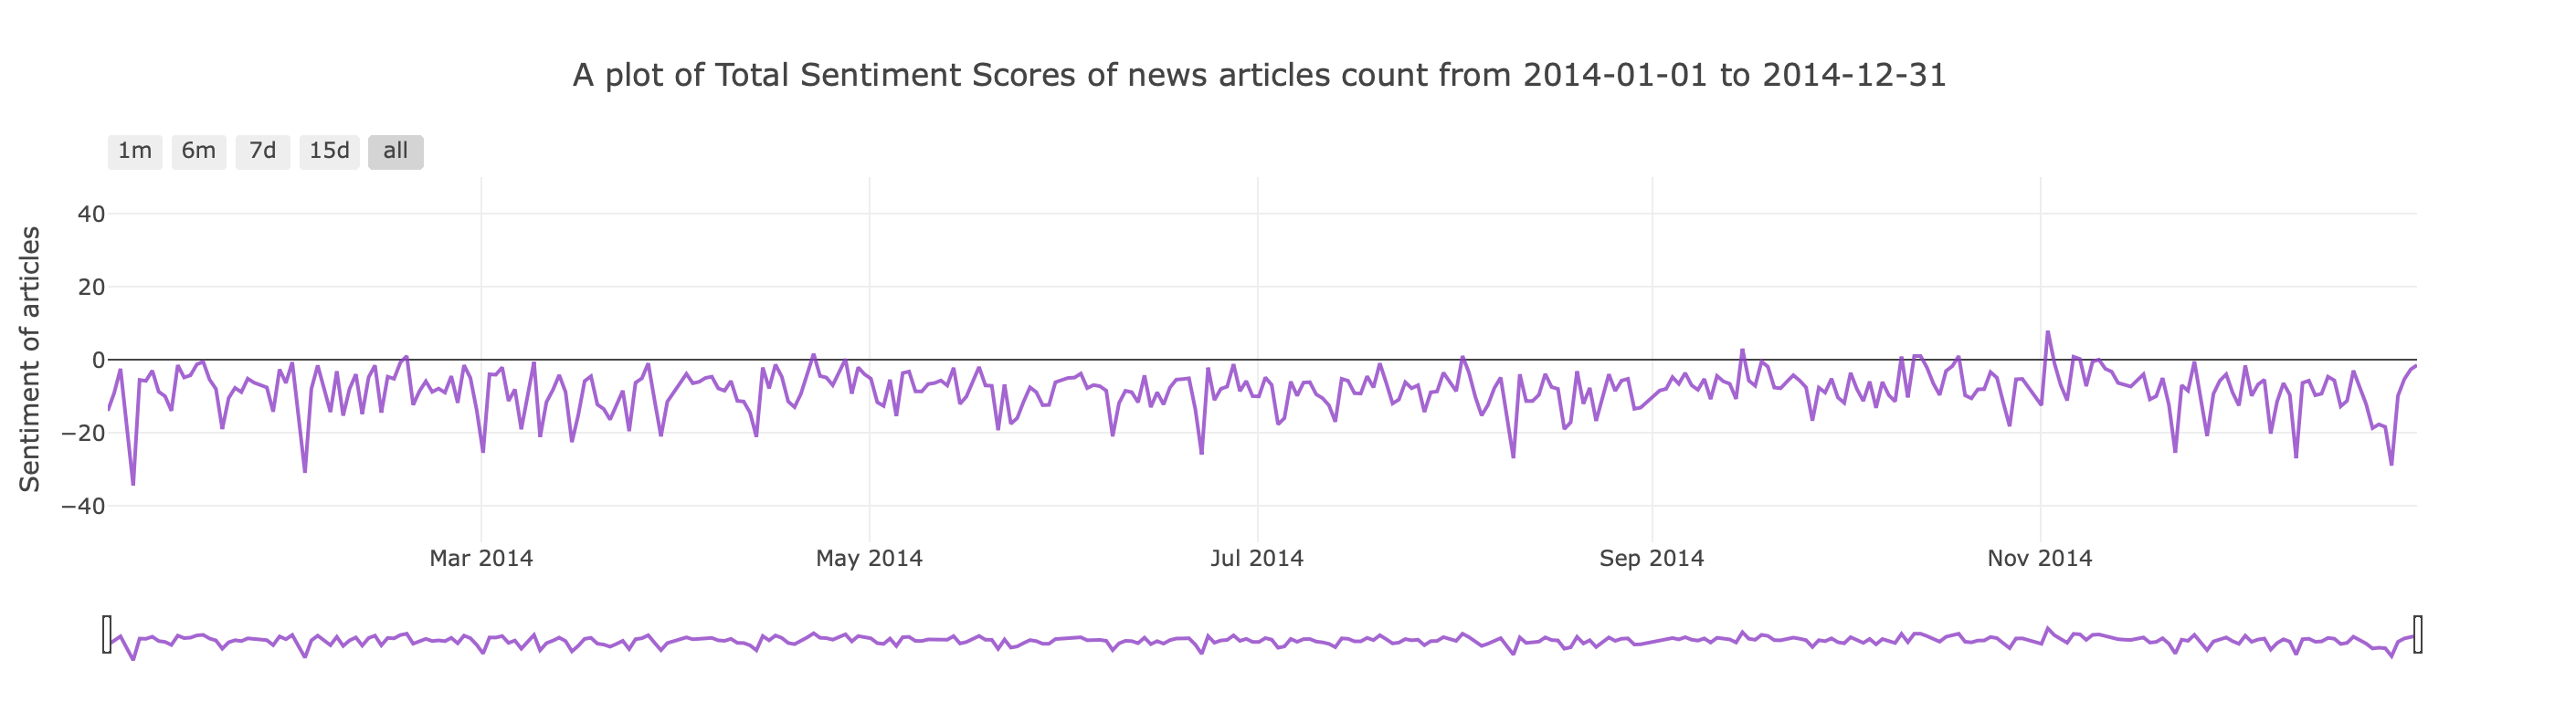

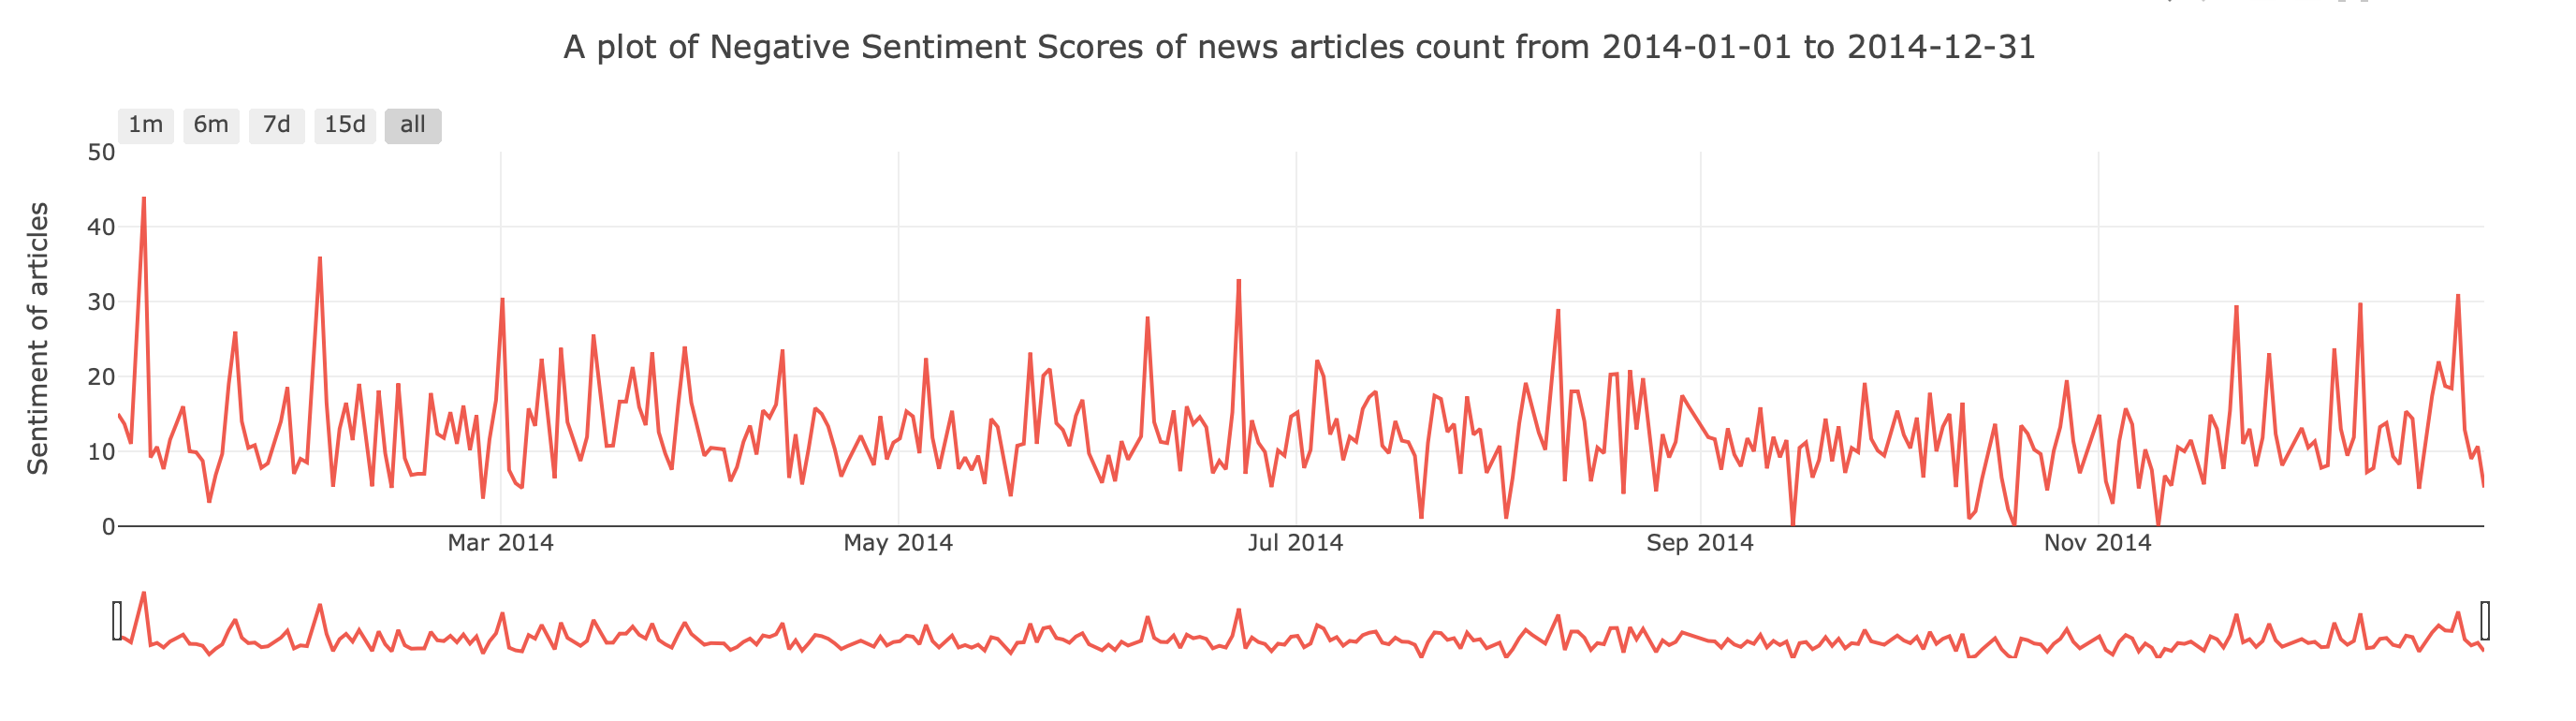

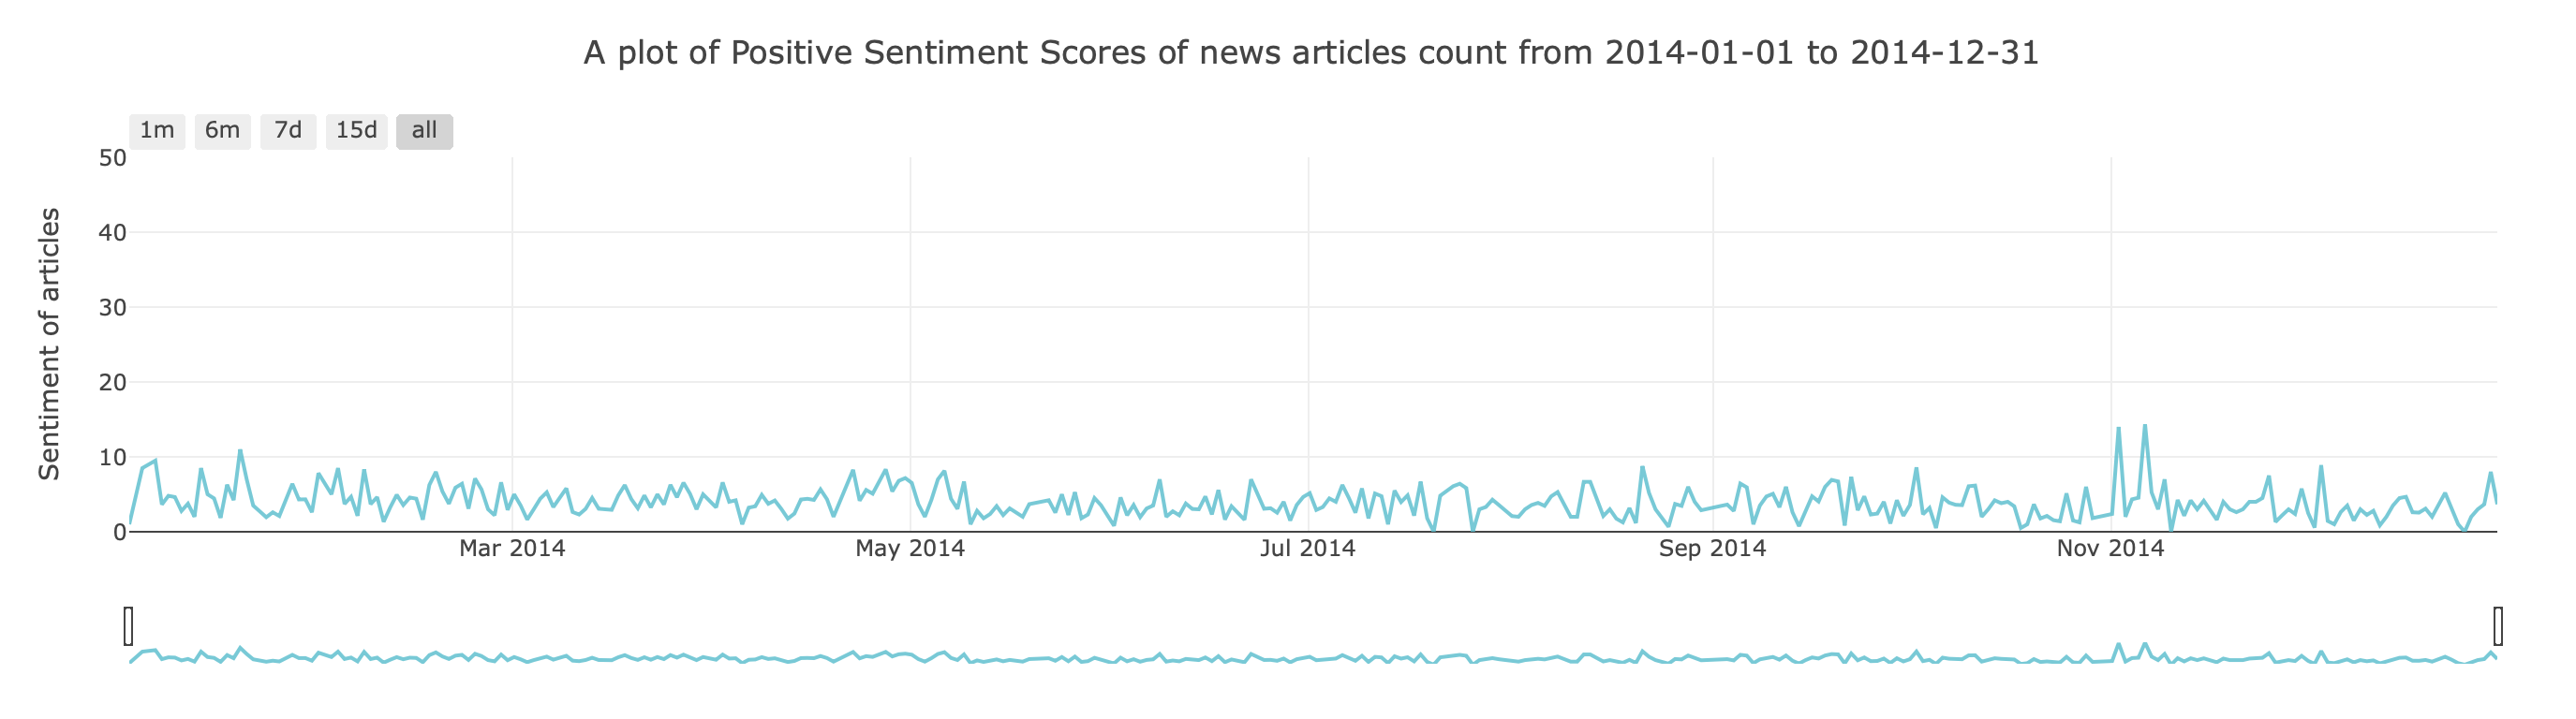